In [81]:
# Import libraries
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
from skimage import io, color, transform
import os
import time
import cv2
from Reshape import resize_and_align_faces
import shutil
import csv

In [82]:
dataset_path = 'D:/AI1708/CPV301/Facedec_src/'
width  = 200
height = 200

In [83]:

train_image_names = [filename for filename in os.listdir(dataset_path) if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
training_tensor = np.empty((len(train_image_names), height * width), dtype=np.float64)
plt.figure(figsize=(10, 30))
for i in range(len(train_image_names)):
    img = io.imread(dataset_path + train_image_names[i])
    img = color.rgb2gray(img)
    img = transform.resize(img, (height, width))
    img_flat = img.flatten()
    training_tensor[i, :] = img_flat

<Figure size 1000x3000 with 0 Axes>

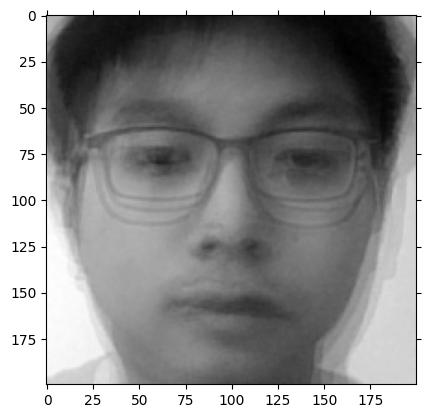

In [84]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [85]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)

In [86]:
plt.figure(figsize=(10, 30))
for i in range(len(train_image_names)):
    img = normalised_training_tensor[i].reshape(height,width)
#     plt.subplot(24,13,1+i)
#     plt.imshow(img, cmap='gray')
#     plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
# plt.show()

<Figure size 1000x3000 with 0 Axes>

In [87]:
cov_matrix = np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix,6.0)
print('Covariance matrix of X: \n%s' %cov_matrix)

Covariance matrix of X: 
[[ 1.69464449e-03 -5.47895649e-04 -2.59222294e-04 -4.13038071e-04
  -4.72576298e-05 -4.27230846e-04]
 [-5.47895649e-04  1.52478204e-03 -7.93614508e-04 -2.61823922e-04
  -1.09581948e-04  1.88133988e-04]
 [-2.59222294e-04 -7.93614508e-04  2.19901208e-03 -2.64771826e-04
  -5.09995149e-04 -3.71408307e-04]
 [-4.13038071e-04 -2.61823922e-04 -2.64771826e-04  1.64339609e-03
  -6.98622301e-06 -6.96776051e-04]
 [-4.72576298e-05 -1.09581948e-04 -5.09995149e-04 -6.98622301e-06
   1.02539141e-03 -3.51570460e-04]
 [-4.27230846e-04  1.88133988e-04 -3.71408307e-04 -6.96776051e-04
  -3.51570460e-04  1.65885168e-03]]


In [88]:
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
print('Eigenvectors of Cov(X): \n%s' %eigenvectors)
print('\nEigenvalues of Cov(X): \n%s' %eigenvalues)

Eigenvectors of Cov(X): 
[[-0.40824829 -0.18228406 -0.80842951 -0.1873076  -0.33383682 -0.00405351]
 [-0.40824829  0.53426246  0.19810786  0.05633016 -0.29597648 -0.64643257]
 [-0.40824829 -0.72025151  0.25189124  0.43796362  0.03972228 -0.24027462]
 [-0.40824829 -0.10535767  0.48365416 -0.58557139 -0.29077806  0.40108105]
 [-0.40824829  0.09661801 -0.09410761 -0.30129332  0.84469683 -0.10417128]
 [-0.40824829  0.37701277 -0.03111616  0.57987853  0.03617225  0.59385094]]

Eigenvalues of Cov(X): 
[4.33680869e-19 2.94618302e-03 2.13483718e-03 2.42090063e-03
 1.04583210e-03 1.19832486e-03]


In [89]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]    

Cumulative proportion of variance explained vector: 
[0.30229422 0.55069165 0.76973743 0.892692   1.         1.        ]


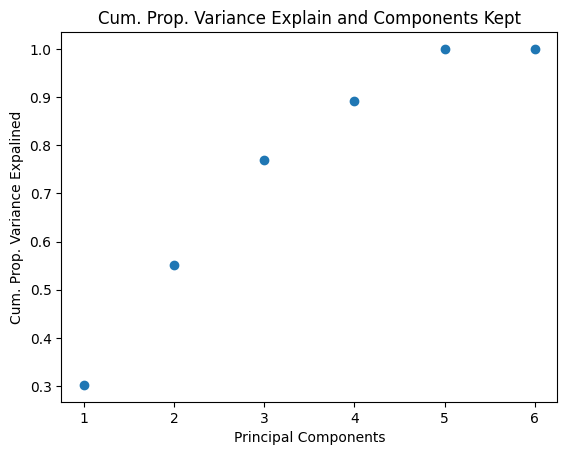

In [90]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

In [100]:
reduced_data = np.array(eigvectors_sort[:7]).transpose()
# reduced_data.shape
training_tensor.shape

(6, 40000)

In [101]:
proj_data = np.dot(training_tensor.transpose(),reduced_data)
proj_data = proj_data.transpose()
proj_data.shape

(6, 40000)

In [93]:
for i in range(proj_data.shape[0]):
    img = proj_data[i].reshape(height,width)

In [94]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
w

array([[ -166.66337764,  -160.34106707,  -418.64540094,    30.60189283,
          -82.64645893,  -834.44258721],
       [  464.09255027,   150.45937817,   111.66571453,  -258.50919116,
          -76.90351708,  2028.70998769],
       [ -501.44643421,   265.12033457,   129.97668032,   -75.67613846,
            9.73316293,  -121.63271361],
       [ -159.98732938,  -456.80237461,   237.7328151 ,   187.24102386,
          -70.39349919, -1978.30330499],
       [   49.16320686,  -201.16929973,   -50.47096304,   -13.85296037,
          212.59354232,  -412.57791935],
       [  314.8413841 ,   402.73302867,   -10.25884595,   130.19537329,
            7.61676995,  1318.24653747]])

In [97]:

output_folder = "D:/AI1708/CPV301/Facedec"

cap = cv2.VideoCapture(0)
cap.set(3, 1280)  # Width
cap.set(4, 720)   # Height

# có thể thay bằng đường dẫn vào ổ trong máy bằng đường dẫn gg drive

while True:
    success, img = cap.read()
    if success and img is not None and img.shape[0] > 0 and img.shape[1] > 0:
        cv2.imshow("Camera", img)
    key = cv2.waitKey(1)

    if key == ord('s'):
        output_path = os.path.join(output_folder, "captured_image.jpg")
        input_folder = "D:/AI1708/CPV301/Facedec"
        output_folder = "D:/AI1708/CPV301/Facedec_r"
        shutil.rmtree(input_folder)
        os.mkdir(input_folder)
        shutil.rmtree(output_folder)
        os.mkdir(output_folder)
        cv2.imwrite(output_path, img)
        resize_and_align_faces(input_folder, output_folder)
        def recogniser(img, train_image_names,proj_data,w):
            
            unknown_face = plt.imread('D:/AI1708/CPV301/Facedec_r/'+img)
            unknown_face = color.rgb2gray(unknown_face)
            unknown_face = transform.resize(unknown_face, (height, width))
            unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
            normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)

            w_unknown = np.dot(proj_data, normalised_uface_vector)
            diff  = w - w_unknown
            norms = np.linalg.norm(diff, axis=1)
            index = np.argmin(norms)

            t1 = 100111536
            t0 = 88831687

            if norms[index] < t1: # It's a face
                if norms[index] < t0: # It's a face in data
                    if img.split('.')[0] == train_image_names[index].split('.')[0]:
                        filename = train_image_names[index]
                        name = filename.split('.')[0]
                        timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
                        csv_file_path = 'D:/AI1708/attendance.csv'
                        with open(csv_file_path, 'a', newline='') as csv_file:
                            csv_writer = csv.writer(csv_file)
                            if os.path.getsize(csv_file_path) == 0:
                                csv_writer.writerow(['Name', 'Time'])
                            csv_writer.writerow([name, timestamp])
                        correct_pred += 1
                    else:   # It's not a face in data
                        filename = train_image_names[index]
                        name = filename.split('.')[0]
                        timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
                        csv_file_path = 'D:/AI1708/attendance.csv'
                        with open(csv_file_path, 'a', newline='') as csv_file:
                            csv_writer = csv.writer(csv_file)
                            if os.path.getsize(csv_file_path) == 0:
                                csv_writer.writerow(['Name', 'Time'])
                            csv_writer.writerow([name, timestamp])

        dataset_path = 'D:/AI1708/CPV301/Facedec_r/'
        test_image_names = [filename for filename in os.listdir(dataset_path) if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        for i in range(len(test_image_names)):
            recogniser(test_image_names[i], train_image_names,proj_data,w)

        break
    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
